In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import lightgbm
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e26/sample_submission.csv
/kaggle/input/playground-series-s3e26/train.csv
/kaggle/input/playground-series-s3e26/test.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e26/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s3e26/test.csv")

In [3]:
train_df.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [4]:
train_df.isna().sum()

id               0
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64

In [5]:
print(train_df.columns)

Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status'],
      dtype='object')


In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df = train_df.drop("id", axis=1)
columns = train_df.columns
categorical_cols = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage", "Status"]
train_df[categorical_cols] = train_df[categorical_cols].apply(lambda col: le.fit_transform(col))
test_df[categorical_cols[:-1]] = test_df[categorical_cols[:-1]].apply(lambda col: le.fit_transform(col))
train_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999,0,21532,1,0,0,0,0,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,2,2
1,2574,1,19237,0,0,0,0,0,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,2,0
2,3428,1,13727,0,0,1,1,2,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,3,2
3,2576,1,18460,0,0,0,0,0,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,2,0
4,788,1,16658,0,0,1,0,0,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,3,0


In [7]:
print(train_df["Stage"].unique())

[2 3 1 0]


<Axes: >

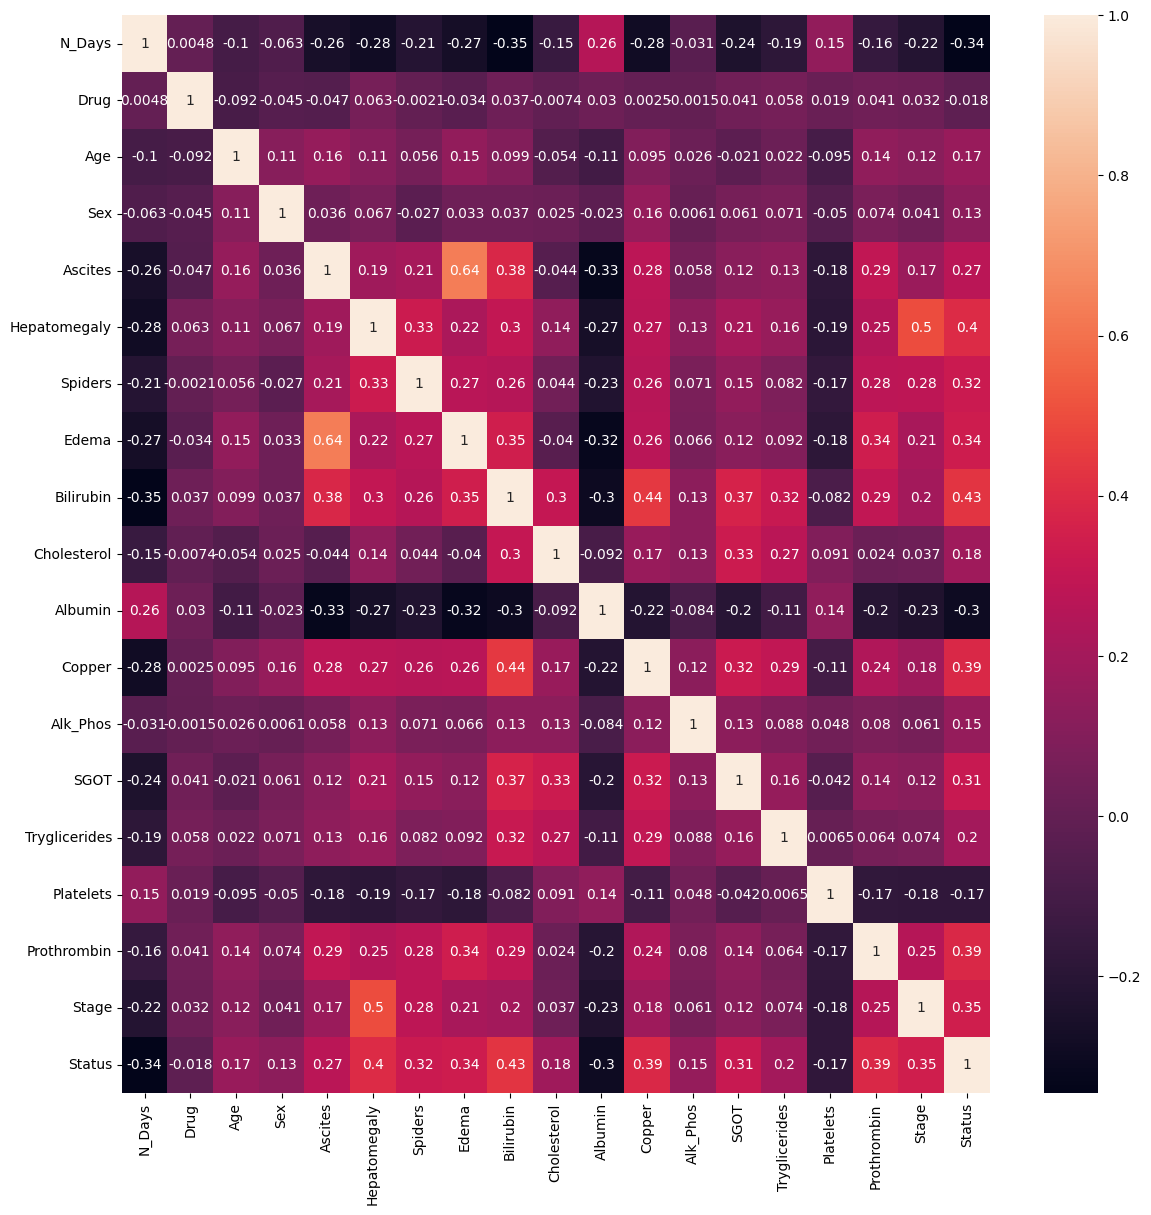

In [8]:
correlations = train_df.corr()
plt.figure(figsize=(14,14))
sns.heatmap(correlations, annot=True)

In [9]:
print(correlations["Status"])

N_Days          -0.343450
Drug            -0.018139
Age              0.168331
Sex              0.130688
Ascites          0.273860
Hepatomegaly     0.396451
Spiders          0.324339
Edema            0.336720
Bilirubin        0.429480
Cholesterol      0.184869
Albumin         -0.296121
Copper           0.386015
Alk_Phos         0.154623
SGOT             0.313242
Tryglicerides    0.197093
Platelets       -0.173318
Prothrombin      0.388080
Stage            0.346768
Status           1.000000
Name: Status, dtype: float64


In [10]:
non_categorical_cols = ["N_Days", "Age", "Bilirubin", "Cholesterol", "Albumin", "Copper", 
                        "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", 
                        "Prothrombin"]
non_category_df = pd.DataFrame(train_df[non_categorical_cols])
non_category_df.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
0,999,21532,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7
1,2574,19237,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0
2,3428,13727,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7
3,2576,18460,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7
4,788,16658,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6


<Axes: >

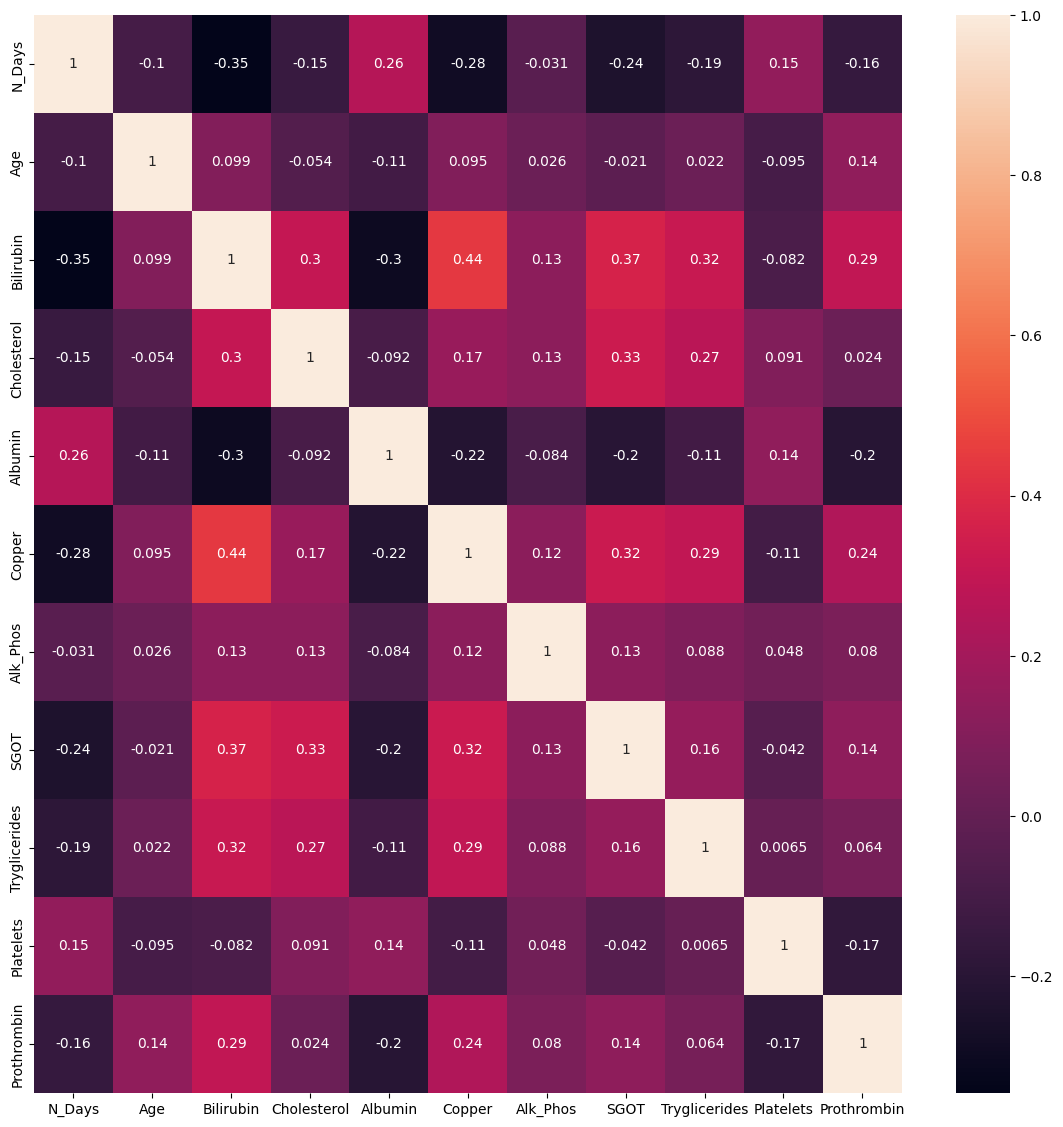

In [11]:
correlations = non_category_df.corr()
plt.figure(figsize=(14,14))
sns.heatmap(correlations, annot=True)

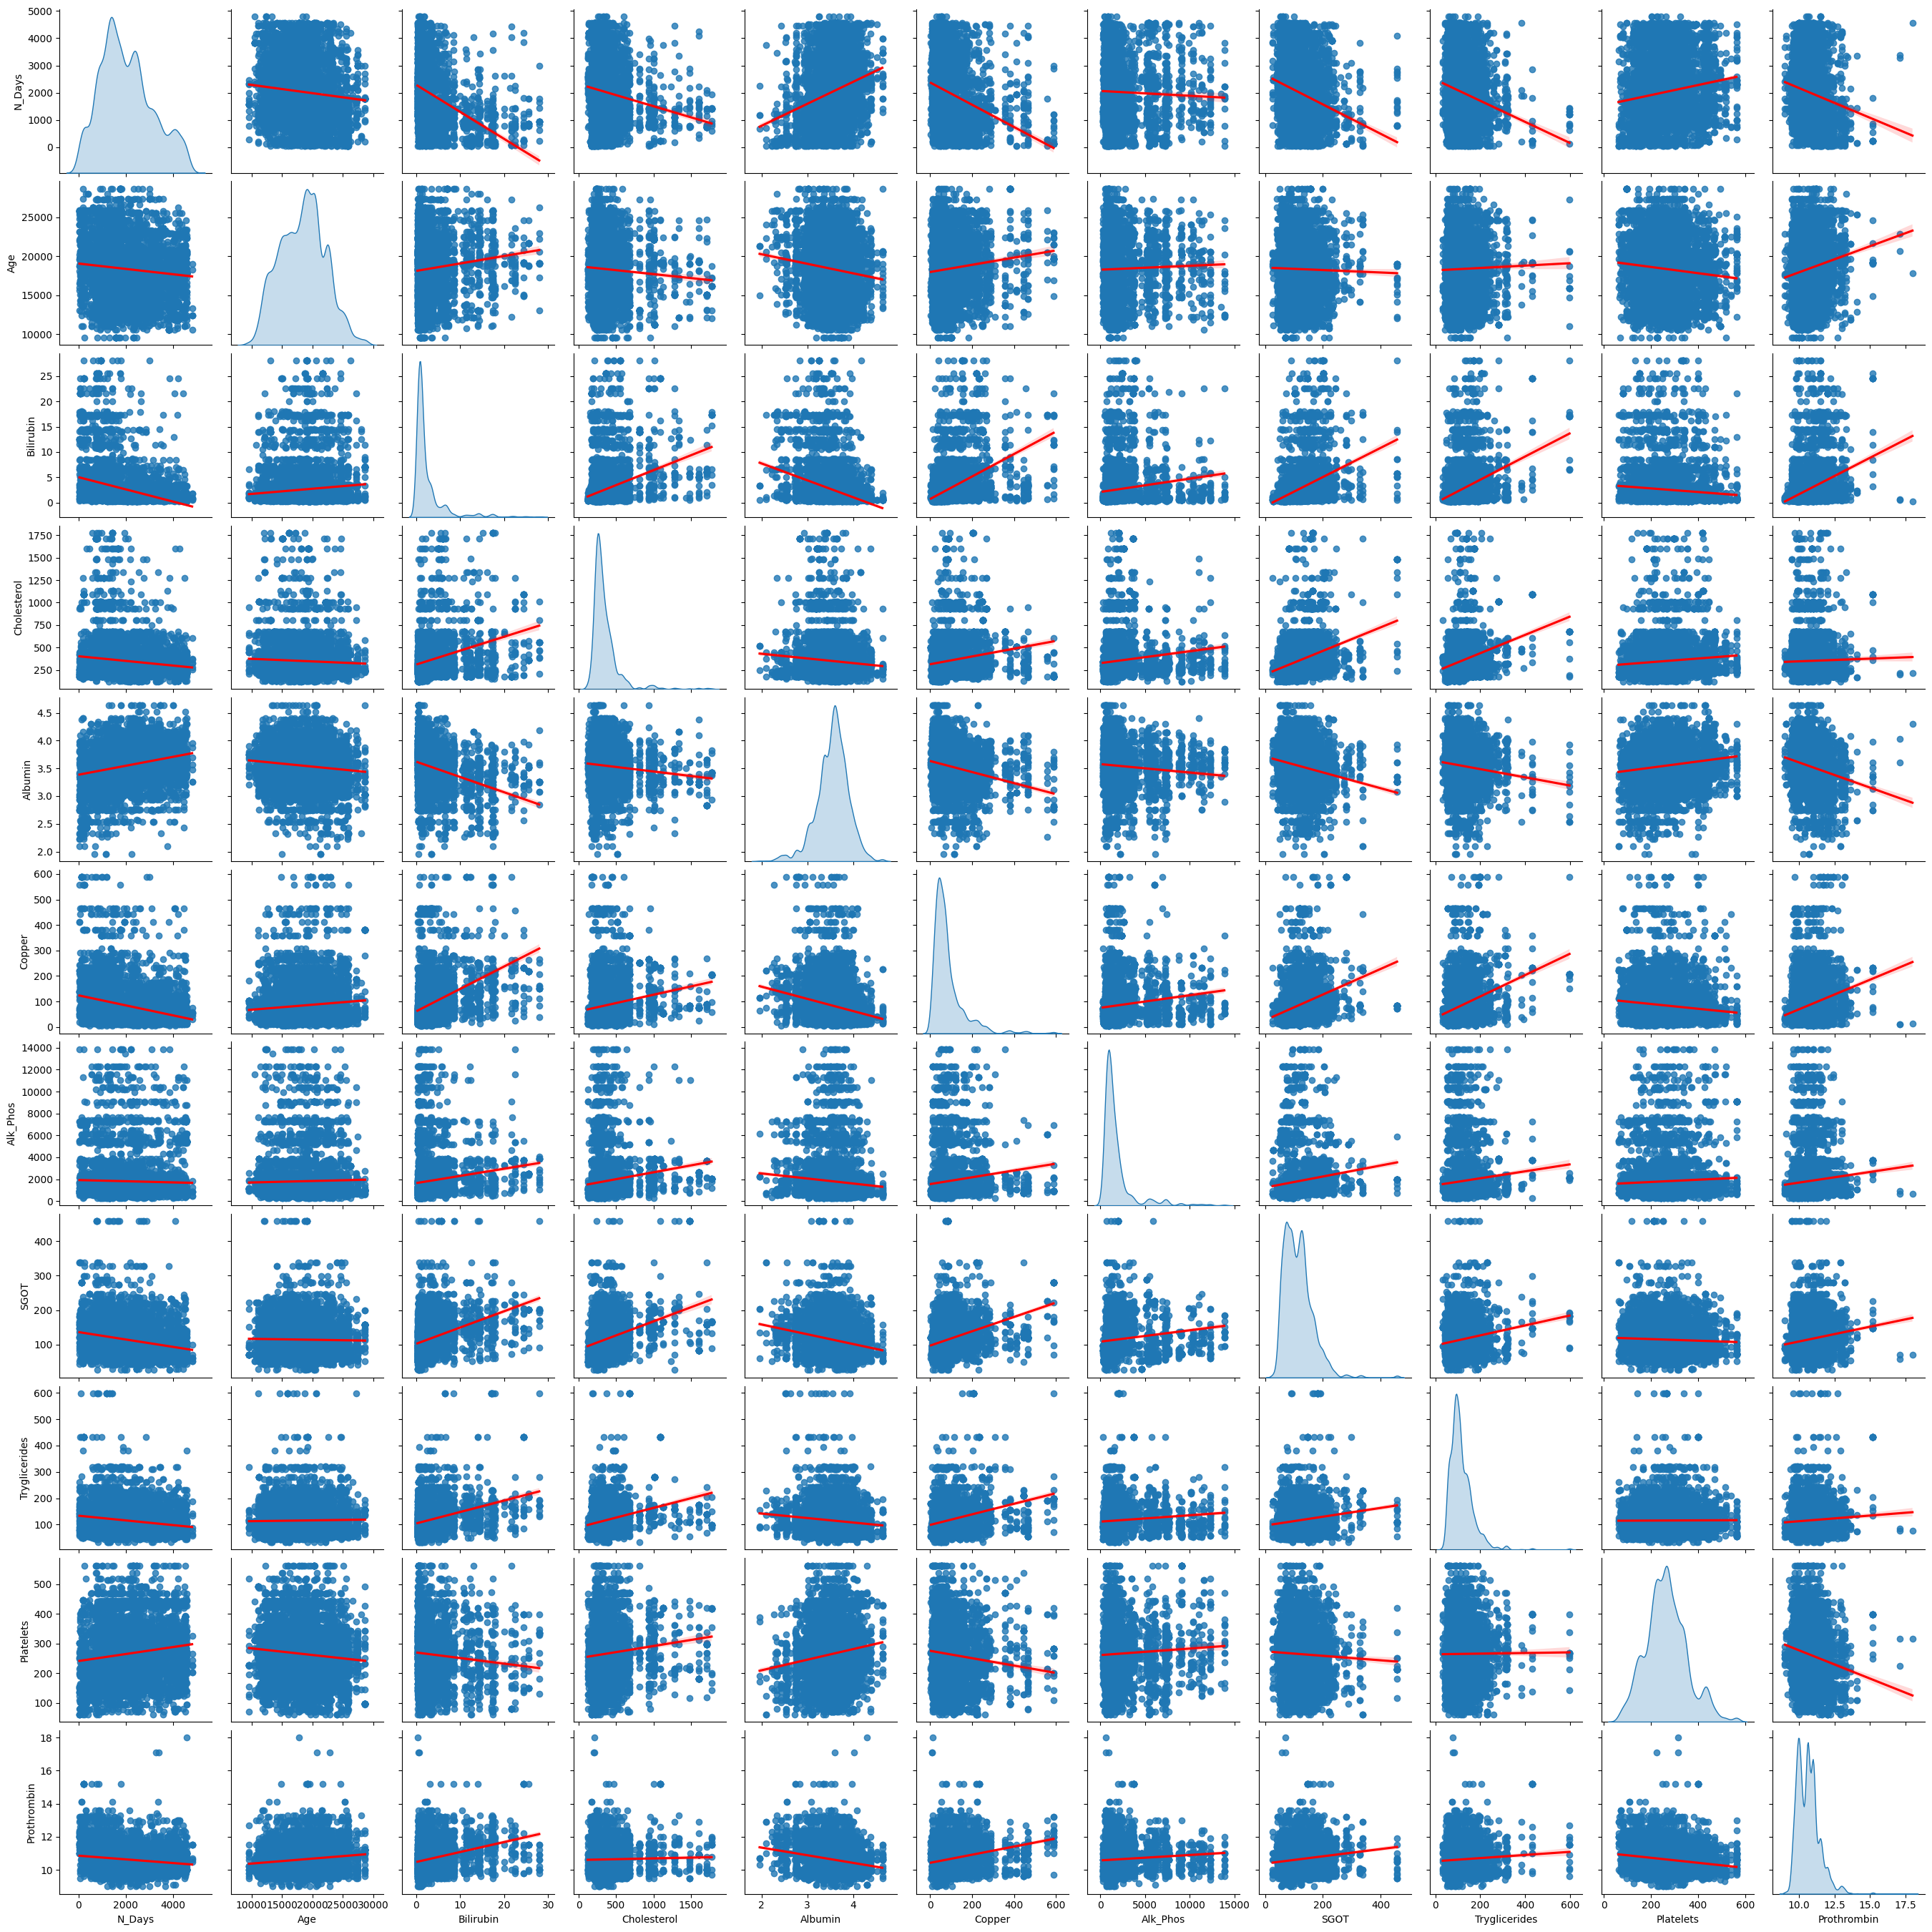

In [12]:
sns.pairplot(non_category_df, kind='reg', diag_kind='kde', plot_kws={'line_kws':{'color':'red'}})